# Meta-SGD Evaluation of Untrained TTTMLP

This notebook instantiates a TTTMLP differentiable memory with its weights fixed to one and evaluates recall quality after inner-loop updates with the ManualSGD meta-optimizer across different learning rates.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from func_memory_module import TTTMLP
from meta_optimizers import ManualSGD
from losses import windowed_p_loss
from synthetic_datasets import InContextRecallDataset
from evaluate_functions import (
    compute_recall_accuracies,
    average_accuracy_across_sequences,
    average_correct_retrievals_across_sequences,
)
from torch.func import functional_call


In [23]:
def adapt_with_meta_sgd(module: TTTMLP, dataset: InContextRecallDataset, lr: float, momentum: float = momentum) -> dict[str, torch.Tensor]:
    inner_opt = ManualSGD()
    params = make_functional_params(module)
    state = inner_opt.init_states(params)
    state = {"v": {name: buf.detach().clone() for name, buf in state["v"].items()}}

    for t in range(len(dataset)):
        key_window, value_window = dataset[t]
        key_window = key_window.to(device)
        value_window = value_window.to(device)

        predictions = functional_call(module, params, key_window)
        loss = windowed_p_loss(predictions.T, value_window.T)

        param_items = list(params.items())
        grads_tuple = torch.autograd.grad(
            loss,
            tuple(p for _, p in param_items),
            allow_unused=True,
        )
        grads = {}
        for (name, param), grad in zip(param_items, grads_tuple):
            if grad is None:
                grads[name] = torch.zeros_like(param)
            else:
                grads[name] = grad

        updated_params, updated_state = inner_opt.step(
            params,
            grads,
            state,
            lr=lr,
            beta=momentum,
        )

        params = detach_params_for_next_step(updated_params)
        state = {"v": {name: buf.detach().clone() for name, buf in updated_state["v"].items()}}

    return detach_params_for_eval(params)


def evaluate_learning_rate(lr: float) -> list[list[torch.Tensor]]:
    histories: list[list[torch.Tensor]] = []
    for dataset in datasets:
        module = create_memory_module(key_dim, val_dim, num_layers=3, device=device)
        module.train()
        final_params = adapt_with_meta_sgd(module, dataset, lr, momentum=momentum)
        module.eval()

        history = compute_recall_accuracies(
            module,
            dataset.inputs,
            dataset.targets,
            params=final_params,
        )
        histories.append(history)
    return histories


def compute_outer_product_histories(dataset: InContextRecallDataset) -> list[torch.Tensor]:
    keys = dataset.inputs.to(device)
    values = dataset.targets.to(device)
    cumulative_matrix = torch.zeros(val_dim, key_dim, device=device)
    history: list[torch.Tensor] = []
    with torch.no_grad():
        for t in range(keys.shape[0]):
            key_t = keys[t]
            value_t = values[t]
            cumulative_matrix = cumulative_matrix + torch.outer(value_t, key_t)

            window_keys = keys[: t + 1]
            window_values = values[: t + 1]

            predictions = (cumulative_matrix @ window_keys.T).T
            logits = predictions @ window_values.T
            predicted_indices = logits.argmax(dim=-1)
            target_indices = torch.arange(t + 1, device=predicted_indices.device)
            per_key_accuracy = (predicted_indices == target_indices).to(torch.float32)
            history.append(per_key_accuracy.flip(0))
    return history


histories_by_lr = {lr: evaluate_learning_rate(lr) for lr in learning_rates}
outer_product_histories = [compute_outer_product_histories(dataset) for dataset in datasets]
print("Computed recall histories for each learning rate and outer-product baseline")



Using device: cuda
Prepared 200 synthetic sequences


In [28]:
accuracy_by_model: dict[str, tuple[torch.Tensor, torch.Tensor]] = {}
retrievals_by_model: dict[str, tuple[torch.Tensor, torch.Tensor]] = {}
plot_labels: list[str] = []

for lr, histories in histories_by_lr.items():
    label = f"Meta-SGD lr={lr}"
    mean_accuracy, counts = average_accuracy_across_sequences(histories)
    mean_retrievals, retrieval_counts = average_correct_retrievals_across_sequences(histories)
    accuracy_by_model[label] = (mean_accuracy.cpu(), counts.cpu())
    retrievals_by_model[label] = (mean_retrievals.cpu(), retrieval_counts.cpu())
    plot_labels.append(label)

outer_label = "Outer-product sum"
mean_accuracy, counts = average_accuracy_across_sequences(outer_product_histories)
mean_retrievals, retrieval_counts = average_correct_retrievals_across_sequences(outer_product_histories)
accuracy_by_model[outer_label] = (mean_accuracy.cpu(), counts.cpu())
retrievals_by_model[outer_label] = (mean_retrievals.cpu(), retrieval_counts.cpu())
plot_labels.append(outer_label)

for label in plot_labels:
    mean_accuracy, _ = accuracy_by_model[label]
    print(f"{label} | Offset 0 accuracy: {mean_accuracy[0].item():.3f}")



Computed recall histories for each learning rate


In [29]:
plt.figure(figsize=(7, 4))
for label in plot_labels:
    mean_accuracy, counts = accuracy_by_model[label]
    offsets = np.arange(mean_accuracy.shape[0])
    mask = counts.numpy() > 0
    style = {"marker": "o"}
    if label == outer_label:
        style.update({"linestyle": "--", "marker": "x"})
    plt.plot(offsets[mask], mean_accuracy.numpy()[mask], label=label, **style)

plt.xlabel("Offset (0 = current timestep)")
plt.ylabel("Recall accuracy")
plt.title("Recall accuracy across models")
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.legend()
plt.show()



Learning rate 0.1 | Offset 0 accuracy: 0.092
Learning rate 0.5 | Offset 0 accuracy: 0.092
Learning rate 0.7 | Offset 0 accuracy: 0.029


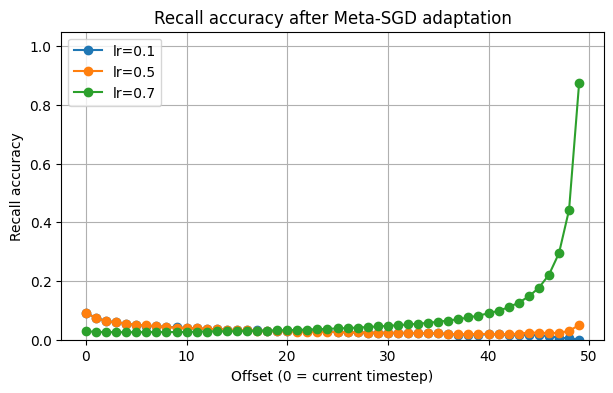

In [30]:
plt.figure(figsize=(7, 4))
for label in plot_labels:
    mean_retrievals, counts = retrievals_by_model[label]
    timesteps = np.arange(mean_retrievals.shape[0])
    mask = counts.numpy() > 0
    style = {"marker": "s"}
    if label == outer_label:
        style.update({"linestyle": "--", "marker": "d"})
    plt.plot(timesteps[mask], mean_retrievals.numpy()[mask], label=label, **style)

plt.xlabel("Timestep")
plt.ylabel("Average correct retrievals")
plt.title("Average correct retrievals across models")
plt.grid(True)
plt.legend()
plt.show()



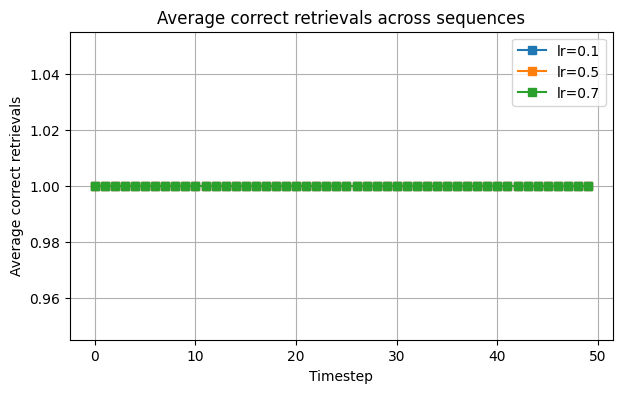

In [31]:
plt.figure(figsize=(7, 4))
for lr in learning_rates:
    mean_retrievals, counts = retrievals_by_lr[lr]
    timesteps = np.arange(mean_retrievals.shape[0])
    mask = counts.numpy() > 0
    plt.plot(timesteps[mask], mean_retrievals.numpy()[mask], marker="s", label=f"lr={lr}")

plt.xlabel("Timestep")
plt.ylabel("Average correct retrievals")
plt.title("Average correct retrievals across sequences")
plt.grid(True)
plt.legend()
plt.show()
